# Week 4 Assignment  
## K Means Clustering

In this assignment I will be segmenting the dataset using the k means algorythm

In [1]:
%matplotlib inline

# Import libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
sns.set_style('whitegrid')
sns.set_context('talk')

# Eliminate false positive SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Make results reproducible
np.random.seed(1234567890)

df = pd.read_csv('gapminder.csv')

variables = ['incomeperperson', 'alcconsumption', 'co2emissions', 'femaleemployrate', 
                'internetuserate', 'lifeexpectancy','polityscore','employrate','urbanrate'] 

# convert to numeric format
for variable in variables:
    df[variable] = pd.to_numeric(df[variable], errors='coerce')

# listwise deletion of missing values
subset = df[variables].dropna()

# Print the rows and columns of the data frame
print('Size of study data')
print(subset.shape)

Size of study data
(148, 9)


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


## Data Management  

In [2]:
n_estimators=25

subset['incomequartiles'] = pd.cut(subset['incomeperperson'], 3, labels=['0%-33%','34%-66%','67%-100%'])
subset['incomequartiles'] = subset['incomequartiles'].astype('category')

variables.pop(0)

predictors = subset[variables]
targets = subset['incomequartiles']

#Split into training and testing sets+
training_data, test_data, training_target, test_target  = train_test_split(predictors, targets, test_size=.3)

# Build the random forest classifier
classifier=RandomForestClassifier(n_estimators=n_estimators)
classifier=classifier.fit(training_data,training_target)

predictions=classifier.predict(test_data)

# Fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(training_data,training_target)

# Display the relative importance of each attribute
feature_name = list(predictors.columns.values)
feature_importance = list(model.feature_importances_)
features = pd.DataFrame({'name':feature_name, 'importance':feature_importance}).sort_values(by='importance', ascending=False)
print(features.head(len(feature_name)))

   importance              name
4    0.345270    lifeexpectancy
3    0.241906   internetuserate
7    0.098684         urbanrate
2    0.098142  femaleemployrate
0    0.074849    alcconsumption
6    0.062126        employrate
1    0.049287      co2emissions
5    0.029736       polityscore


In [3]:
variables = ['incomeperperson', 'lifeexpectancy', 'internetuserate', 'urbanrate'] 

# convert to numeric format
for variable in variables:
    df[variable] = pd.to_numeric(df[variable], errors='coerce')

# listwise deletion of missing values
subset = df[variables].dropna()

# Print the rows and columns of the data frame
print('Size of study data')
print(subset.shape)

subset['incomequartiles'] = pd.cut(subset['incomeperperson'], 3, labels=['0%-33%','34%-66%','67%-100%'])
subset['incomequartiles'] = subset['incomequartiles'].astype('category')

# Remove the first variable from the list since the target is derived from it
variables.pop(0)

# Center and scale data
for variable in variables:
    subset[variable]=preprocessing.scale(subset[variable].astype('float64'))
    
features = subset[variables]
targets = subset[['incomeperperson']]

Size of study data
(173, 4)


### Split Data into Training and Test Sets  

In [4]:
training_data, test_data, training_target, test_target  = train_test_split(features, targets, test_size=.3)
print('Size of training data')
print(training_data.shape)

Size of training data
(121, 3)


## Determine the Number of Clusters

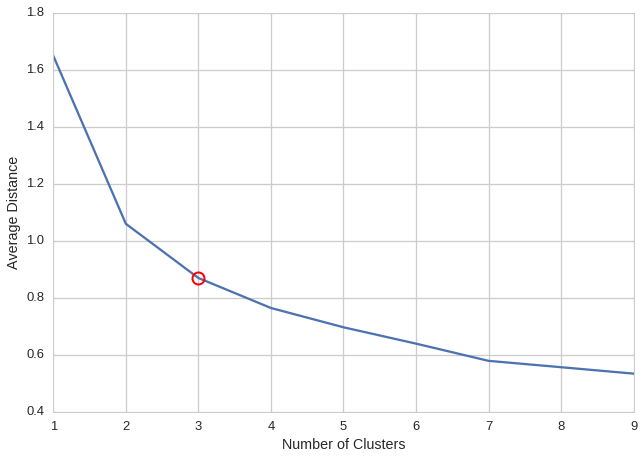

In [5]:
# Identify number of clusters using the elbow method
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(training_data)
    clusassign=model.predict(training_data)
    dist = sum(np.min(cdist(training_data, model.cluster_centers_, 'euclidean'), axis=1))
    meandist.append(dist / training_data.shape[0])

# Visualize the elbow
k = 3

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(clusters, meandist)
ax.plot(clusters[(k-1)], meandist[(k-1)], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Average Distance')
plt.show()

## Visualize Clustered Data

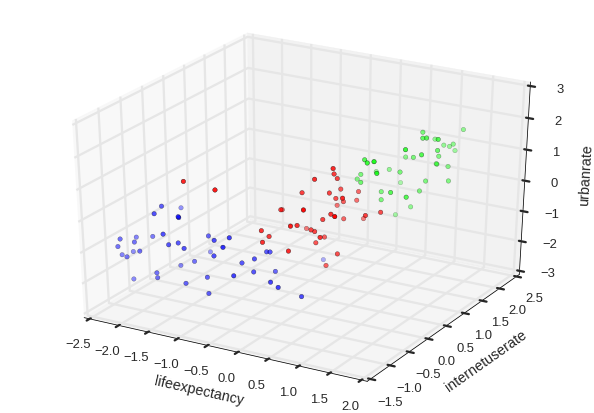

In [6]:
model=KMeans(n_clusters=k)
model.fit(training_data)
training_data['cluster'] = model.labels_
# Change Colors
my_cmap = plt.cm.get_cmap('brg')
my_cmap.set_under('w')

x = training_data.iloc[:,0]
y = training_data.iloc[:,1]
z = training_data.iloc[:,2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=training_data['cluster'], cmap=my_cmap)
ax.set_xlabel(training_data.columns.values[0], labelpad=15)
ax.set_ylabel(training_data.columns.values[1], labelpad=15)
ax.set_zlabel(training_data.columns.values[2], labelpad=15)
plt.show()

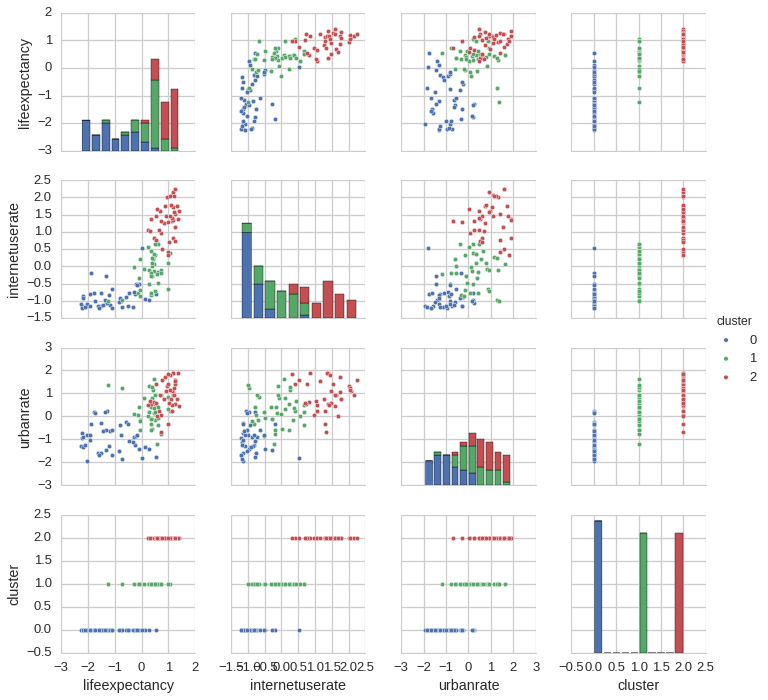

In [7]:
sns.pairplot(training_data, hue ='cluster');

## Examine Differences Between Clusters

In [8]:
# Add Cluster label to training targets
training_target['cluster'] = model.labels_
# OLS regression
income_model = smf.ols(formula='incomeperperson ~ C(cluster)', data=training_target).fit()
print (income_model.summary())

                            OLS Regression Results                            
Dep. Variable:        incomeperperson   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     95.04
Date:                Wed, 24 Feb 2016   Prob (F-statistic):           2.57e-25
Time:                        22:49:34   Log-Likelihood:                -1247.4
No. Observations:                 121   AIC:                             2501.
Df Residuals:                     118   BIC:                             2509.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        1069.3599   1121.487     

In [9]:
print ('means for features by cluster')
m1= training_target.groupby('cluster').mean()
print (m1)

means for features by cluster
         incomeperperson
cluster                 
0            1069.359893
1            3330.299958
2           21766.156497


In [10]:
print ('standard deviations for features by cluster')
m2= training_target.groupby('cluster').std()
print (m2)

standard deviations for features by cluster
         incomeperperson
cluster                 
0            1743.196576
1            2695.976196
2           12542.466920


In [11]:
mc1 = multi.MultiComparison(training_target['incomeperperson'], training_target['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
group1 group2  meandiff    lower      upper    reject
-----------------------------------------------------
  0      1    2260.9401  -1599.3376 6121.2177  False 
  0      2    20696.7966 16836.519  24557.0742  True 
  1      2    18435.8565 14482.5468 22389.1663  True 
-----------------------------------------------------


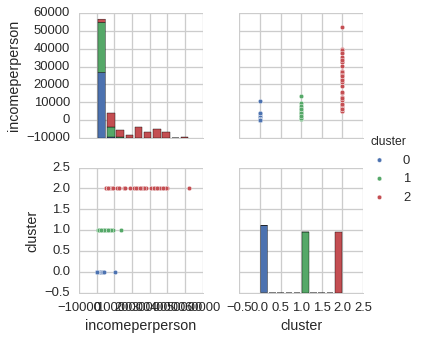

In [12]:
sns.pairplot(training_target, hue ='cluster');